In [1]:
import pandas
import numpy
import csv
import os
import warnings
from tqdm import tqdm
from functions import *

from pytest import skip

df_user_info = pandas.read_csv('user_list_more_than_20.csv')
df_anime_x = pandas.read_csv('top_and_bottom_anime.csv')
df_anime_y = pandas.read_csv('anime_matrix_true.csv')

#create main split for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_anime_x, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
X_cross_train, X_cross_test, y_cross_train, y_cross_test = train_test_split(X_train, y_train, test_size=0.2, random_state=69)

In [2]:
#Same spits are performed again to create df_true to check accuracy 
#create main split for training and testing
from sklearn.model_selection import train_test_split
A_train, A_test, b_train, b_test = train_test_split(df_anime_y, df_anime_y, test_size=0.2, random_state=42)

#create cross training split for building the models
A_cross_train, A_cross_test, b_cross_train, b_cross_test = train_test_split(A_train, b_train, test_size=0.2, random_state=69)

df_true = A_cross_test.copy()

In [3]:
#create user list
watch_values = y_cross_train.values
users = y_cross_train.columns[1:]

#get rows of anime in the test list
rows = X_cross_test['Id'].copy()

#create watch list based on df_anime_y
users_watched = []
for i in tqdm(range(len(users))):
    watched = []
    for j in range(len(watch_values)):
        if(watch_values[j][i+1]):
            watched.append(str(watch_values[j][0]))
    users_watched.append(watched)

100%|██████████| 9028/9028 [00:03<00:00, 2429.90it/s]


In [4]:
#creates anime watched true values
anime = []
for i in range(len(df_anime_x)):
    anime.append(df_anime_x.loc[i]['Id'])

users_watched = []
header = ['Id']
for i in range(len(df_user_info)):
    header.append(df_user_info.loc[i]['user'])
    try:
        users_watched.append(df_user_info.loc[i]["watched list"].split())
    except:
        users_watched.append([])    #append empty list if the user has no watch list


result = []
for i in tqdm(range(len(anime))):
    id = anime[i].replace('\'','')
    temp = [id]
    for j in range(len(users_watched)):
        if id in users_watched[j]:
            temp.append(1)
        else:
            temp.append(0)
    result.append(temp)

outputdf = pandas.DataFrame(result, columns=header)
outputdf.to_csv('anime_matrix_true_knn.csv', index=False)

 81%|████████▏ | 453/556 [00:40<00:09, 11.19it/s]


KeyboardInterrupt: 

# Compute All Distances

In [ ]:
#compute all distances and dump to file
#for Create_soup_selection choose all, or choose between studio, source, genre, va
test = X_cross_test.copy()
train = X_cross_train.copy()

all_distances = []
for j in tqdm(range(len(test))):
    bag1 = Create_soup_selection(test.iloc[j],studio=False,source=True,genre=True,va=True).split()
    distances = []
    for i in range(len(train)):
        bag2 = Create_soup_selection(train.iloc[i],studio=False,source=True,genre=True,va=True).split()
        distances.append((train.iloc[i]['Id'].replace('\'',''),Jaccard(list(bag1),list(bag2))))
    Sort_Tuple(distances)
    all_distances.append(distances)

import pickle

# open a file, where you ant to store the data
file = open('knn_distances_all__', 'wb')

# dump information to that file
pickle.dump(all_distances, file)

# close the file
file.close()

100%|██████████| 89/89 [00:04<00:00, 21.34it/s]


In [5]:
import pickle

# open a file, where you stored the pickled data
file = open('knn_distances_all', 'rb')

# dump information to that file
all_distances = pickle.load(file)

# close the file
file.close()

# Make Predictions

In [6]:
#KNN implementation

#make empty prediction matrix
#add anime Id column from 'rows'
#for every user
#   for each list of distances
#       find value of sum and divide by k
#       if sum / k is >= 0.5 predict 1, else predict 0
#   append to list of predictions

for knn in tqdm(range(11,12)):
    neighbors = 9
    prediction_result = []
    for j in (range(len(users))):
        col = users[j]
        watched = users_watched[j]
        predictions = []
        for k in range(len(all_distances)):
            distances = all_distances[k]
            #compute the sum
            neigh = []
            for i in range(neighbors):
                neigh.append(distances[i][0])
            value = len(list(set(neigh).intersection(watched)))
            if (value / neighbors) > 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        prediction_result.append(predictions)

    #create df_predictions
    warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
    df_predictions = pandas.DataFrame()
    df_predictions['Id'] = rows
    for i in range(len(users)):
        col = users[i]
        df_predictions[col] = prediction_result[i]

    #write to csv
    outputdf = df_predictions.copy()
    outputdf.to_csv(f'predictions_matrix_{neighbors}nn.csv', index=False)

100%|██████████| 1/1 [00:37<00:00, 37.67s/it]


# Evaluation

In [64]:
#This block is the same as 
#KNN implementation

#make empty prediction matrix
#add anime Id column from 'rows'
#for every user
#   for each list of distances
#       find value of sum and divide by k
#       if sum / k is >= 0.5 predict 1, else predict 0
#   append to list of predictions
k_value = []
k_acc = []
for knn in tqdm(range(1,26)):
    neighbors = knn
    prediction_result = []
    for j in (range(len(users))):
        col = users[j]
        watched = users_watched[j]
        predictions = []
        for k in range(len(all_distances)):
            distances = all_distances[k]
            #compute the sum
            neigh = []
            for i in range(neighbors):
                neigh.append(distances[i][0])
            value = len(list(set(neigh).intersection(watched)))
            if (value / neighbors) >= 0.5:
                predictions.append(1)
            else:
                predictions.append(0)
        prediction_result.append(predictions)

    #create df_predictions
    warnings.simplefilter(action='ignore', category=pandas.errors.PerformanceWarning)
    df_predictions = pandas.DataFrame()
    df_predictions['Id'] = rows
    for i in range(len(users)):
        col = users[i]
        df_predictions[col] = prediction_result[i]

    #write to csv
    outputdf = df_predictions.copy()
    outputdf.to_csv(f'predictions_matrix_{neighbors}nn.csv', index=False)

    #caluclate accuracy
    value = 0
    prediction_matrix = pandas.read_csv(f'predictions_matrix_{neighbors}nn.csv')
    pred_values = prediction_matrix.values
    true_values = df_true.values
    predict_watch = 0
    true_watch = 0
    false_pos = 0
    false_neg = 0
    null = 0

    num_row = len(pred_values)
    num_col = len(pred_values[0])
    for i in tqdm(range(num_row)):
        for j in range(1,num_col):          #first item is the anime id, so we skip it
            if pred_values[i,j] == true_values[i,j]:
                value += 1
            if pred_values[i,j] == 1:
                predict_watch += 1 
                if true_values[i,j] == 0:
                    false_pos += 1
            if true_values[i,j] == 1:
                true_watch += 1
                if pred_values[i,j] == 0:
                    false_neg += 1
            if 0 == true_values[i,j]:
                null += 1

    #subtracting 1 from column length b/c the first item is the anime id
    percent = (value / ((num_row) * (num_col-1))) * 100
    total = (num_row) * (num_col-1)
    # print(f'Total predictions: {total}')
    # print(f'Correct predictions: {value}')

    # print(f'Predicted watch: {predict_watch}')
    # print(f'True watched: {true_watch}')
    # print(f'False positive: {false_pos}')
    # print(f'False negative: {false_neg}')
    # print(f'Null Error Rate: {(null / total)*100: .2f}')
    # print(f'Percent correct: {percent: .2f}%')

    k_value.append(knn)
    k_acc.append(percent)

  0%|          | 0/25 [00:06<?, ?it/s]


KeyboardInterrupt: 

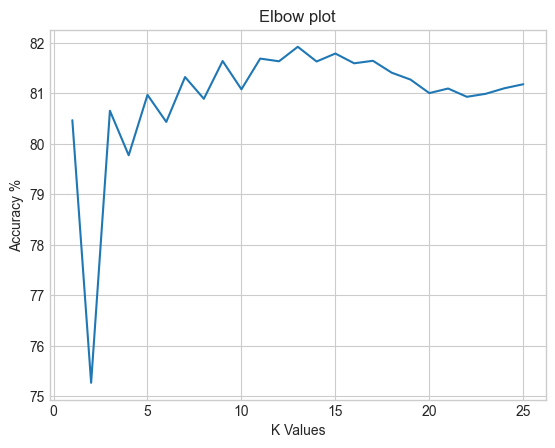

In [53]:
import matplotlib.pyplot as plt

plt.plot(k_value,k_acc)
plt.title('Elbow plot')
plt.ylabel('Accuracy %')
plt.xlabel('K Values')
plt.show()

In [194]:
labels = ['all','drop va','drop genre','drop source', 'drop studio']
percent_val = []

In [222]:
from sklearn import accuracy_score

percent_val.insert(0, accuracy_score(y_true, y_pred))
percent_val

[0.8168942565700716,
 0.8131095269150159,
 0.7916631403921881,
 0.8111792027798659,
 0.8192776032617624]

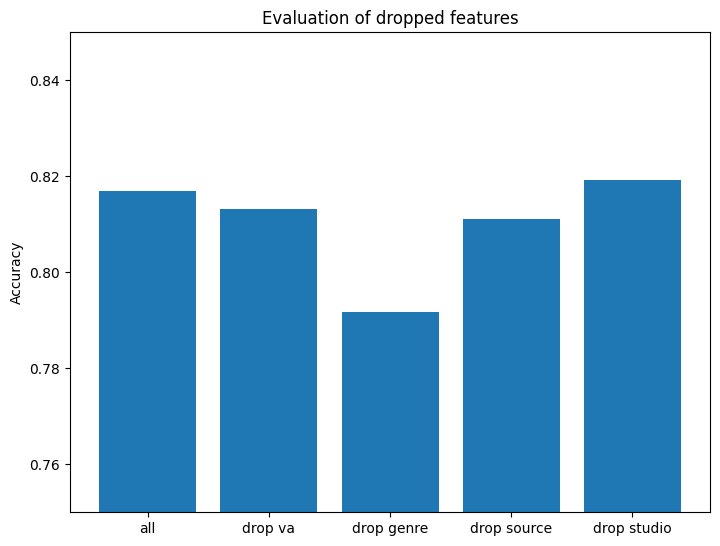

In [227]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim(0.75,0.85)

ax.bar(labels,percent_val)
ax.set_ylabel('Accuracy')
ax.set_title('Evaluation of dropped features')
plt.show()

In [7]:
#caluclate accuracy
correct = 0
prediction_matrix = pandas.read_csv('predictions_matrix_11nn.csv')
pred_values = prediction_matrix.values
true_values = df_true.values
predict_watch = 0
true_watch = 0
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
null = 0

num_row = len(pred_values)
num_col = len(pred_values[0])
for i in tqdm(range(num_row)):
    for j in range(1,num_col):          #first item is the anime id, so we skip it
        if pred_values[i,j] == true_values[i,j]:
            correct += 1
        if pred_values[i,j] == 1:
            predict_watch += 1
            if true_values[i,j] == 1:
                true_pos += 1
                true_watch += 1
            else:
                false_pos += 1

        if pred_values[i,j] == 0:
            if true_values[i,j] == 0:
                true_neg += 1
            else:
                false_neg += 1
                true_watch += 1

        if 0 == true_values[i,j]:
            null += 1
        

#subtracting 1 from column length b/c the first item is the anime id
percent = (correct / ((num_row) * (num_col-1)))
total = (num_row) * (num_col-1)
print(f'Total predictions: {total}')
print(f'Correct predictions: {correct}')

print(f'Predicted watch: {predict_watch}')
print(f'True watched: {true_watch}')
print(f'True positive: {true_pos}')
print(f'True negative: {true_neg}')
print(f'False negative: {false_neg}')
print(f'Null Error Rate: {(null / total)*100: .2f}')
print(f'False positive: {false_pos}')
print(f'Percent correct: {percent * 100: .2f}%')
print(f'Precision: {(true_pos / (true_pos + false_pos)): .2f}')
print(f'Recall: {(true_pos / (true_pos + false_neg)): .2f}')

100%|██████████| 89/89 [00:02<00:00, 42.27it/s]

Total predictions: 803492
Correct predictions: 658283
Predicted watch: 126475
True watched: 185064
True positive: 83165
True negative: 575118
False negative: 101899
Null Error Rate:  76.97
False positive: 43310
Percent correct:  81.93%
Precision:  0.66
Recall:  0.45


C:\Users\Tenkawa PC\AppData\Local\Temp\ipykernel_1056\678633288.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax= plt.subplot()


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

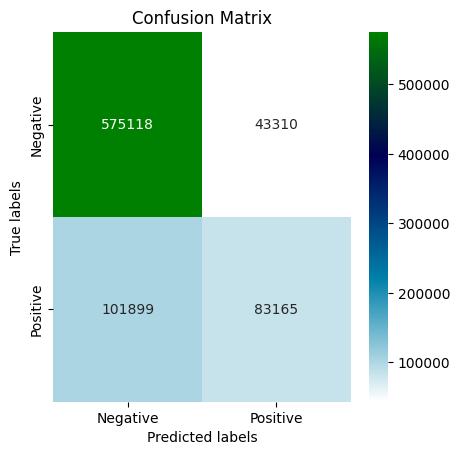

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

#have to convert true_values and pred_values from matrix to list
y_true = []
y_pred = []
for i in range(len(true_values)):
    y_true += list(true_values[i][1:])
    y_pred += list(pred_values[i][1:])

cm = confusion_matrix(y_true,y_pred)
plt.matshow(cm)

   

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='ocean_r');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(f'Accuray: {accuracy_score(y_true, y_pred):.2f}')
print(f'Precision: {precision_score(y_true, y_pred):.2f}')
print(f'Recall: {recall_score(y_true, y_pred):.2f}')
print(f'F1 score: {f1_score(y_true, y_pred):.2f}')

Accuray: 0.82
Precision: 0.66
Recall: 0.45
F1 score: 0.53
